In [1]:
import torch_geometric as tgm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import networkx as nx

from sklearn.model_selection import train_test_split as tts

from src.Dataset import HiC_Dataset

In [2]:
bigwigs = os.listdir("Data/raw/bigwigs")
contacts = os.listdir("Data/raw/contacts")
target = "target.tsv"

In [3]:
train_dset = HiC_Dataset("Data",
                   contacts=contacts,
                   bigwigs=bigwigs,
                   target=target)

In [4]:
fnames = ['Mbd3',
          'WT_CTCF',
          'KO_CTCF',
          'WT_Smc3',
          'KO_Smc3',
          '0h_H3K27ac',
          '1h_H3K27ac',
          '24h_H3K27ac',
          '48h_H3K27ac',
          'WT_Nanog',
          'KO_Nanog',
          'WT_Klf4',
          'KO_Klf4',
          '0h_H3K4me3',
          '24h_H3K4me3',
          'KO_Chd4',
          '24h_Chd4',
          '48h_Chd4']

In [5]:
def torch_to_nx(arch, fnames= fnames):
    G = nx.Graph()
    G.add_nodes_from([(idx, 
                     {fnames[jdx]: arch.x.numpy()[idx,jdx] for jdx in np.arange(len(fnames))
                     }
                     ) for idx in np.arange(arch.x.numpy().shape[0])
                     ]
                   )
    G.add_edges_from([(arch.edge_index.numpy()[0,idx],
                       arch.edge_index.numpy()[1,idx],
                     {'WT_weight': arch.edge_attr.numpy()[idx,0],
                      'KO_weight': arch.edge_attr.numpy()[idx,1],
                      'backbone': arch.edge_attr.numpy()[idx,2],
                      }
                     ) for idx in np.arange(arch.edge_index.numpy().shape[1])
                     ])
    
    return G, arch.name

In [6]:
def symlog(vec):
    out = vec.copy()
    out[vec>1]=1+np.log(out[vec>1])

    return out

def draw_graph(G,
               ax, 
               weight = 'WT_weight',
               color_nodes_by = 'Mbd3',
               node_cmap = 'Blues',
               edge_cmap = 'Reds',
               log_node_color = True,
               log_edge_weight = True
               ):
  
    pos = nx.spring_layout(G, weight = weight)

    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist = [25],
                           node_size = 500,
                           node_color = 'red',
                           ax = ax
                           )

    node_cols = np.array([G.nodes[node][color_nodes_by] for node in G.nodes()])
    if log_node_color:
        node_cols = symlog(node_cols)

    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_color=node_cols,
                           cmap = node_cmap,
                           node_size = 150,
                           ax = ax
                           )
    
    edge_weights = np.array([G[edge[0]][edge[1]][weight] for edge in G.edges()])
    if log_edge_weight:
        edge_weights = symlog(edge_weights)

    nx.draw_networkx_edges(G,
                           pos,
                           edge_color = edge_weights,
                           edge_cmap = plt.cm.Greys,
                           connectionstyle = 'arc3,rad=0.2',
                           ax = ax 
                           )
    
    nx.draw_networkx_edges(G,
                           pos,
                           edgelist = [edge for edge in G.edges() if G[edge[0]][edge[1]]['backbone']==True],
                           edge_color = 'red',
                           width = 2,
                           connectionstyle = 'arc3,rad=0.2',
                           ax = ax 
                           )
    
    
    


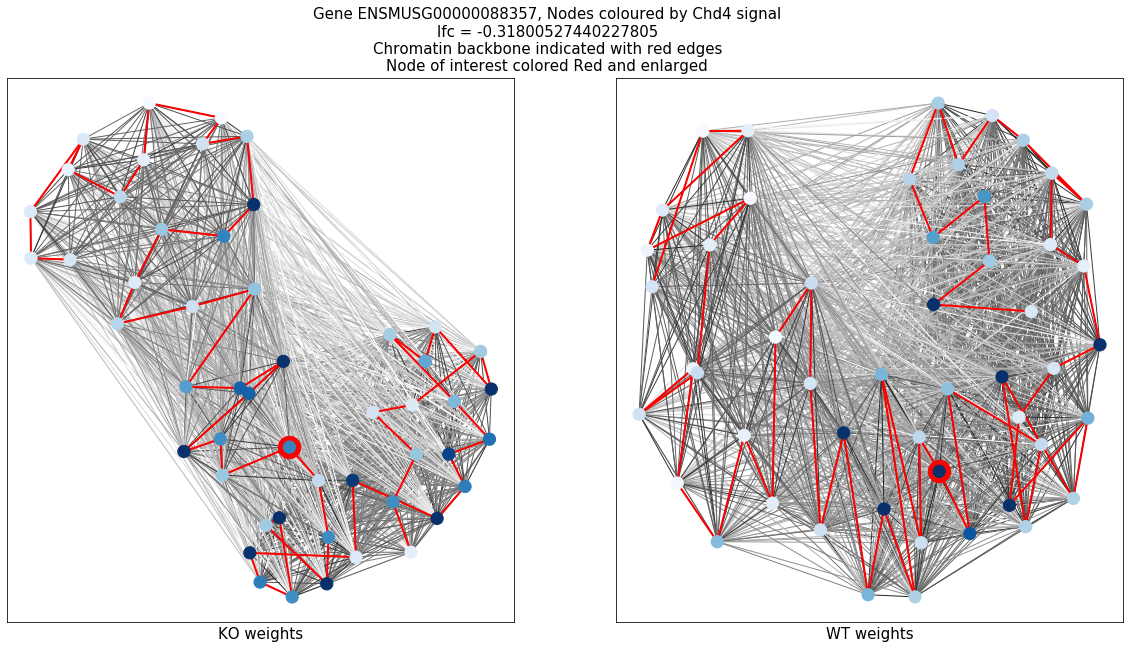

In [8]:
fig,ax = plt.subplots(1,2, figsize = (20,10))
node_col_WT = '48h_Chd4'
node_col_KO = 'KO_Chd4'
idx = 5
dat,name = torch_to_nx(train_dset[idx])
draw_graph(dat,
           ax[1],
           color_nodes_by=node_col_WT)
ax[1].set_xlabel("WT weights", size = 15)

draw_graph(dat,
           ax[0],
           color_nodes_by=node_col_KO, 
           weight = 'KO_weight')
ax[0].set_xlabel("KO weights", size = 15)

title = fig.suptitle(f"Gene {name}, Nodes coloured by Chd4 signal\nlfc = {train_dset[idx].y}\nChromatin backbone indicated with red edges\nNode of interest colored Red and enlarged",
         size = 15)

## Layers

In [254]:
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

from torch.nn.init import xavier_uniform_ as glorot
from torch.nn.init import zeros_ as zeros

class GATCEW(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},

    where the attention coefficients :math:`\alpha_{i,j}` are computed as

    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
        \right)\right)}.
    
    The edge weighted version adds in edge weighting as an extra parameter 
    within the  calculation for alpha{i,j}
    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    def __init__(self, 
                 in_channels, 
                 out_channels,
                 edge_channels,
                 heads=1, 
                 concat=True,
                 negative_slope=0.2, 
                 dropout=0, 
                 bias=True, 
                 **kwargs):
        super(GATCEW, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_channels = edge_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.weight = Parameter(
            torch.Tensor(in_channels, heads * out_channels)).double()
        self.edge_weight = Parameter(
            torch.Tensor(edge_channels, heads * edge_channels)).double()
        
        self.att = Parameter(torch.Tensor(1, heads, 2 * out_channels + edge_channels))

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels)).double()
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels)).double()
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

        
    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.att)
        zeros(self.bias)

    def forward(self, x, edge_index, edge_attr, size=None):
        '''
        if size is None and torch.is_tensor(x):
            edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
            median_weight = torch.median(edge_attr)
            edge_index, edge_attr = add_self_loops(edge_index,
                                                   edge_weight = edge_attr,
                                                   num_nodes=x.size(0),
                                                   fill_value = median_weight
                                                  )
            size = None
        ''' 
        if torch.is_tensor(x):
            x = torch.matmul(x, self.weight)
        else:
            x = (None if x[0] is None else torch.matmul(x[0], self.weight),
                 None if x[1] is None else torch.matmul(x[1], self.weight))
        
        if torch.is_tensor(edge_attr):
            edge_attr = torch.matmul(edge_attr, self.edge_weight)
        
        return self.propagate(edge_index, size=size, x=x, edge_attr=edge_attr)


    def message(self, edge_index_i, x_i, x_j, edge_attr, size_i):
        # Compute attention coefficients.
        x_j = x_j.view(-1, self.heads, self.out_channels)
        edge_attr = edge_attr.view(-1, self.heads, self.edge_channels)
        
        if x_i is None:
            alpha = (torch.cat([x_j,edge_attr],dim=-1) * self.att[:, :, self.out_channels:]).sum(dim=-1)
        else:
            x_i = x_i.view(-1, self.heads, self.out_channels)
            val = torch.cat([x_i,x_j, edge_attr], dim=-1)
            alpha = (val * self.att).sum(dim=-1)
        
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, edge_index_i, num_nodes = size_i)

        # Sample attention coefficients stochastically.
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        val =  x_j * alpha.view(-1, self.heads, 1)
        print(val.shape)
        return val

    def update(self, aggr_out):
        print("here")
        if self.concat is True:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)

        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)


class GATConv(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},

    where the attention coefficients :math:`\alpha_{i,j}` are computed as

    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
        \right)\right)}.

    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    def __init__(self, in_channels, out_channels, heads=1, concat=True,
                 negative_slope=0.2, dropout=0, bias=True, **kwargs):
        super(GATConv, self).__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.weight = Parameter(
            torch.Tensor(in_channels, heads * out_channels)).double()
        self.att = Parameter(torch.Tensor(1, heads, 2 * out_channels)).double()

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels)).double()
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels)).double()
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.att)
        zeros(self.bias)


    def forward(self, x, edge_index, size=None):
        """"""
        if size is None and torch.is_tensor(x):
            edge_index, _ = remove_self_loops(edge_index)
            edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        if torch.is_tensor(x):
            x = torch.matmul(x, self.weight)
        else:
            x = (None if x[0] is None else torch.matmul(x[0], self.weight),
                 None if x[1] is None else torch.matmul(x[1], self.weight))

        return self.propagate(edge_index, size=size, x=x)


    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients.
        x_j = x_j.view(-1, self.heads, self.out_channels)
        if x_i is None:
            alpha = (x_j * self.att[:, :, self.out_channels:]).sum(dim=-1)
        else:
            x_i = x_i.view(-1, self.heads, self.out_channels)
            alpha = (torch.cat([x_i, x_j], dim=-1) * self.att).sum(dim=-1)

        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, edge_index_i, num_nodes = size_i)

        # Sample attention coefficients stochastically.
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        val = x_j * alpha.view(-1, self.heads, 1)
        
        print(val.shape)
        return val

    def update(self, aggr_out):
        if self.concat is True:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)

        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)


In [255]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
NUMCHIP = train_dset.num_node_features
NUMEDGE = train_dset.num_edge_features

class GATCEW_Net(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GATCEW_Net, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATCEW(NUMCHIP, out_channels = hidden_channels, edge_channels = NUMEDGE)
        self.conv2 = GATCEW(hidden_channels, out_channels = hidden_channels, edge_channels = NUMEDGE)
        self.conv3 = GATCEW(hidden_channels, out_channels = hidden_channels, edge_channels = NUMEDGE)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x.double(), edge_index, edge_attr.double())
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr.double())
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr.double())

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)
        
        return x
    
class GATConv_Net(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GATConv_Net, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(NUMCHIP, out_channels = hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels = hidden_channels)
        self.conv3 = GATConv(hidden_channels, out_channels = hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x.double(), edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)
        
        return x

In [256]:
model = GATConv_Net(hidden_channels=30)
print(model)
dat = train_dset[0]
model(dat.x.double(), 
      dat.edge_index, 
      dat.edge_attr, 
      torch.full((51,),0))

GATConv_Net(
  (conv1): GATConv(18, 30, heads=1)
  (conv2): GATConv(30, 30, heads=1)
  (conv3): GATConv(30, 30, heads=1)
  (lin): Linear(in_features=30, out_features=1, bias=True)
)
torch.Size([2234, 1, 30])


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/disk1/dh486/anaconda3/envs/hicexplorer/lib/python3.7/site-packages/torch_scatter/scatter.py", line 12, in scatter_sum
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast(index, src, dim)
            ~~~~~~~~~ <--- HERE
    if out is None:
        size = list(src.size())
  File "/disk1/dh486/anaconda3/envs/hicexplorer/lib/python3.7/site-packages/torch_scatter/utils.py", line 13, in broadcast
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand_as(other)
          ~~~~~~~~~~~~~ <--- HERE
    return src
RuntimeError: The expanded size of the tensor (1) must match the existing size (2234) at non-singleton dimension 1.  Target sizes: [2234, 1, 30].  Tensor sizes: [1, 2234, 1]


In [ ]:
model = GATCEW_Net(hidden_channels=30)
print(model)
dat = train_dset[0]
model(dat.x.double(), 
      dat.edge_index, 
      dat.edge_attr, 
      torch.full((51,),0))

In [199]:
from torch_geometric.data import DataLoader
train_loader = DataLoader(train_dset, batch_size=3)

In [145]:
for data in train_loader:
    model(data.x, data.edge_index, data.edge_attr, data.batch)

torch.Size([7330, 1, 30]) torch.Size([7330, 1, 30]) torch.Size([7330, 1, 3]) torch.Size([1, 1, 63]) torch.Size([7330, 1, 63])


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/disk1/dh486/anaconda3/envs/hicexplorer/lib/python3.7/site-packages/torch_scatter/scatter.py", line 12, in scatter_sum
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast(index, src, dim)
            ~~~~~~~~~ <--- HERE
    if out is None:
        size = list(src.size())
  File "/disk1/dh486/anaconda3/envs/hicexplorer/lib/python3.7/site-packages/torch_scatter/utils.py", line 13, in broadcast
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand_as(other)
          ~~~~~~~~~~~~~ <--- HERE
    return src
RuntimeError: The expanded size of the tensor (1) must match the existing size (7330) at non-singleton dimension 1.  Target sizes: [7330, 1, 30].  Tensor sizes: [1, 7330, 1]


In [ ]:
class GATCEW(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper
    .. math::
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},
    where the attention coefficients :math:`\alpha_{i,j}` are computed as
    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
        \right)\right)}.
    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    _alpha: OptTensor

    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, 
                 edge_channels: int,
                 heads: int = 1, concat: bool = True,
                 negative_slope: float = 0.2, dropout: float = 0.0,
                 add_self_loops: bool = True, bias: bool = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(GATConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_channels = edge_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        if isinstance(in_channels, int):
            self.lin_l = Linear(in_channels, heads * out_channels, bias=False)
            self.lin_r = self.lin_l
        else:
            self.lin_l = Linear(in_channels[0], heads * out_channels, False)
            self.lin_r = Linear(in_channels[1], heads * out_channels, False)
            
        self.lin_e = Linear(edge_channels, heads*edge_channels, bias=False)

        self.att_l = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = Parameter(torch.Tensor(1, heads, out_channels))

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.lin_l.weight)
        glorot(self.lin_r.weight)
        glorot(self.att_l)
        glorot(self.att_r)
        zeros(self.bias)

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None, return_attention_weights=None):
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels

        x_l: OptTensor = None
        x_r: OptTensor = None
        alpha_l: OptTensor = None
        alpha_r: OptTensor = None
        if isinstance(x, Tensor):
            assert x.dim() == 2, 'Static graphs not supported in `GATConv`.'
            x_l = x_r = self.lin_l(x).view(-1, H, C)
            alpha_l = (x_l * self.att_l).sum(dim=-1)
            alpha_r = (x_r * self.att_r).sum(dim=-1)
        else:
            x_l, x_r = x[0], x[1]
            assert x[0].dim() == 2, 'Static graphs not supported in `GATConv`.'
            x_l = self.lin_l(x_l).view(-1, H, C)
            alpha_l = (x_l * self.att_l).sum(dim=-1)
            if x_r is not None:
                x_r = self.lin_r(x_r).view(-1, H, C)
                alpha_r = (x_r * self.att_r).sum(dim=-1)

        assert x_l is not None
        assert alpha_l is not None

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                num_nodes = x_l.size(0)
                if x_r is not None:
                    num_nodes = min(num_nodes, x_r.size(0))
                if size is not None:
                    num_nodes = min(size[0], size[1])
                edge_index, _ = remove_self_loops(edge_index)
                edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                edge_index = set_diag(edge_index)

        # propagate_type: (x: OptPairTensor, alpha: OptPairTensor)
        out = self.propagate(edge_index, x=(x_l, x_r),
                             alpha=(alpha_l, alpha_r), size=size)

        alpha = self._alpha
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out += self.bias

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, x_j: Tensor, alpha_j: Tensor, alpha_i: OptTensor,
                index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i
        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)
